# Applying normal Timewise PCA

In [1]:
import seaborn as sns
import os
import pandas as pd
from matplotlib.pyplot import title

sns.set_theme(style="ticks")

In [2]:
# Load segmented data
def load_segmented_data(data_folder="", event_name=None):
    """
    Load segmented CSV data.

    Parameters:
    - data_folder (str): Folder where the segmented .csv files are stored.
    - event_name (str or None): Name of the event to load. If None, loads all CSV files.

    Returns:
    - pd.DataFrame: Loaded dataframe with all data concatenated if loading all events.
    """
    if event_name is not None:
        # Load one specific event csv
        file_path = os.path.join(data_folder, f"segment_around_{event_name}.csv")
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"No data found for event '{event_name}' at {file_path}")
        df = pd.read_csv(file_path)
        print(f"Loaded data for event '{event_name}' from {file_path}.")
        return df
    else:
        # Load all csv files in the folder that match pattern 'segment_around_*.csv'
        all_files = [f for f in os.listdir(data_folder) if f.startswith("segment_around_") and f.endswith(".csv")]
        if not all_files:
            raise FileNotFoundError(f"No segmented CSV files found in folder {data_folder}")

        dfs = []
        for file in all_files:
            path = os.path.join(data_folder, file)
            df_temp = pd.read_csv(path)
            # Optionally add a column indicating source event, parsed from filename
            event_from_file = file.replace("segment_around_", "").replace(".csv", "")
            df_temp['EventName'] = event_from_file
            dfs.append(df_temp)
        df_all = pd.concat(dfs, ignore_index=True)
        print(f"Loaded and concatenated {len(all_files)} segmented event files from {data_folder}.")
        return df_all

In [3]:
# Data path
data_folder = "data/cleaned_data/data_segment/Safak"
# Load single event:
df_single_event = load_segmented_data(data_folder=data_folder, event_name="StagEventNew_nearest_neighbor_steeringRemoved")
df_single_event
# Load all events:
# df_all = load_segmented_data(data_folder="data/data_segment")

Loaded data for event 'StagEventNew_nearest_neighbor_steeringRemoved' from data/cleaned_data/data_segment/Safak/segment_around_StagEventNew_nearest_neighbor_steeringRemoved.csv.


,timestamp_REF,uid,dataset,city_section,ExperimentalCondition,UnixTimeStamp,TobiiTimeStamp,RightEyeIsBlinkingWorld,RightEyeIsBlinkingLocal,LeftEyeIsBlinkingWorld,...,TimeStamp,TimeStamp_in_sec,TimeDiff_in_sec,Blink,BlinkDuration,BlinkDurationsLong,BlinkAfter,SamplingRate,time_from_event,outlier
0,2020-09-26 13:46:22.260000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.918274,False,False,False,...,1.601128e+09,139.759740,0.010971,False,0.106051,0.0,False,50.0,-5.00,False
1,2020-09-26 13:46:22.280000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.939484,False,False,False,...,1.601128e+09,139.781682,0.021942,False,0.105959,0.0,False,50.0,-4.98,False
2,2020-09-26 13:46:22.300000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.961914,False,False,False,...,1.601128e+09,139.803248,0.021566,False,0.105866,0.0,False,50.0,-4.96,False
3,2020-09-26 13:46:22.320000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.983795,False,False,False,...,1.601128e+09,139.825190,0.016456,False,0.105774,0.0,False,50.0,-4.94,False
4,2020-09-26 13:46:22.340000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,348.000427,False,False,False,...,1.601128e+09,139.841646,0.016705,False,0.105681,0.0,False,50.0,-4.92,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80155,2020-09-19 10:22:15.060000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.885681,False,False,True,...,1.600511e+09,170.287970,0.009973,False,NaN,0.0,False,50.0,4.92,False
80156,2020-09-19 10:22:15.080000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.907898,False,False,True,...,1.600511e+09,170.310909,0.022938,False,NaN,0.0,False,50.0,4.94,False
80157,2020-09-19 10:22:15.100000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.919006,False,False,True,...,1.600511e+09,170.322876,0.010971,False,NaN,0.0,False,50.0,4.96,False
80158,2020-09-19 10:22:15.120000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.952576,False,False,True,...,1.600511e+09,170.355788,0.022938,False,NaN,0.0,False,50.0,4.98,True


In [ ]:
df_single_event['uid'].nunique()

In [ ]:
df_single_event.columns

# Remap 'SuccessfulCompletionState'

In [4]:
# To see if all values are NaN, only 1, only 0, or mixed
result = df_single_event.groupby('uid')['SuccessfulCompletionState'].agg(
    lambda x: {
        'all_nan': x.isna().all(),
        'all_one': (x == 1).all() if not x.isna().all() else False,
        'all_zero': (x == 0).all() if not x.isna().all() else False,
        'mixed': not (x.isna().all() or (x == 1).all() or (x == 0).all())
    }
)

# To see the actual status info for each uid:
print(result)

uid
0037b2329de444c18d751b4e79901b39    {'all_nan': False, 'all_one': False, 'all_zero...
0117810eb9634c4f98f842021ee6a595    {'all_nan': False, 'all_one': False, 'all_zero...
0121f5b2f59d434f8beb17bf3e2a80b9    {'all_nan': False, 'all_one': False, 'all_zero...
0956f0cca5f546d79a0cf4fbae23d496    {'all_nan': False, 'all_one': False, 'all_zero...
09a23914cf354ea39444511406d16722    {'all_nan': False, 'all_one': False, 'all_zero...
                                                          ...                        
f9c6ff61370141c89ea9bbc536d796e1    {'all_nan': False, 'all_one': False, 'all_zero...
fa2e2604ec6a4820851f032e80f09ba1    {'all_nan': False, 'all_one': False, 'all_zero...
fa4ca90c5b80445b9af0b7ec4fbcc124    {'all_nan': False, 'all_one': False, 'all_zero...
fd19a21a4a8846ca82bd127e4e1933f5    {'all_nan': False, 'all_one': False, 'all_zero...
ff4288f304e74bbf93aa6508c7df8145    {'all_nan': False, 'all_one': False, 'all_zero...
Name: SuccessfulCompletionState, Length: 160, dtyp

In [5]:
# 1. Get the known value (0 or 1) for each uid
# First, identify the non-NaN value per 'uid' (assumes consistent non-NaN)
uid_value = df_single_event.groupby('uid')['SuccessfulCompletionState'].transform(lambda x: x.dropna().unique()[0])

# 2. Fill NaNs with the corresponding uid's value
# For entries where 'SuccessfulCompletionState' is NaN, replace with uid_value
df_single_event['SuccessfulCompletionState'] = df_single_event['SuccessfulCompletionState'].fillna(uid_value)
# To see if all values are NaN, only 1, only 0, or mixed
df_single_event['SuccessfulCompletionState']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
80155    1.0
80156    1.0
80157    1.0
80158    1.0
80159    1.0
Name: SuccessfulCompletionState, Length: 80160, dtype: float64

# 1. Visualize variables

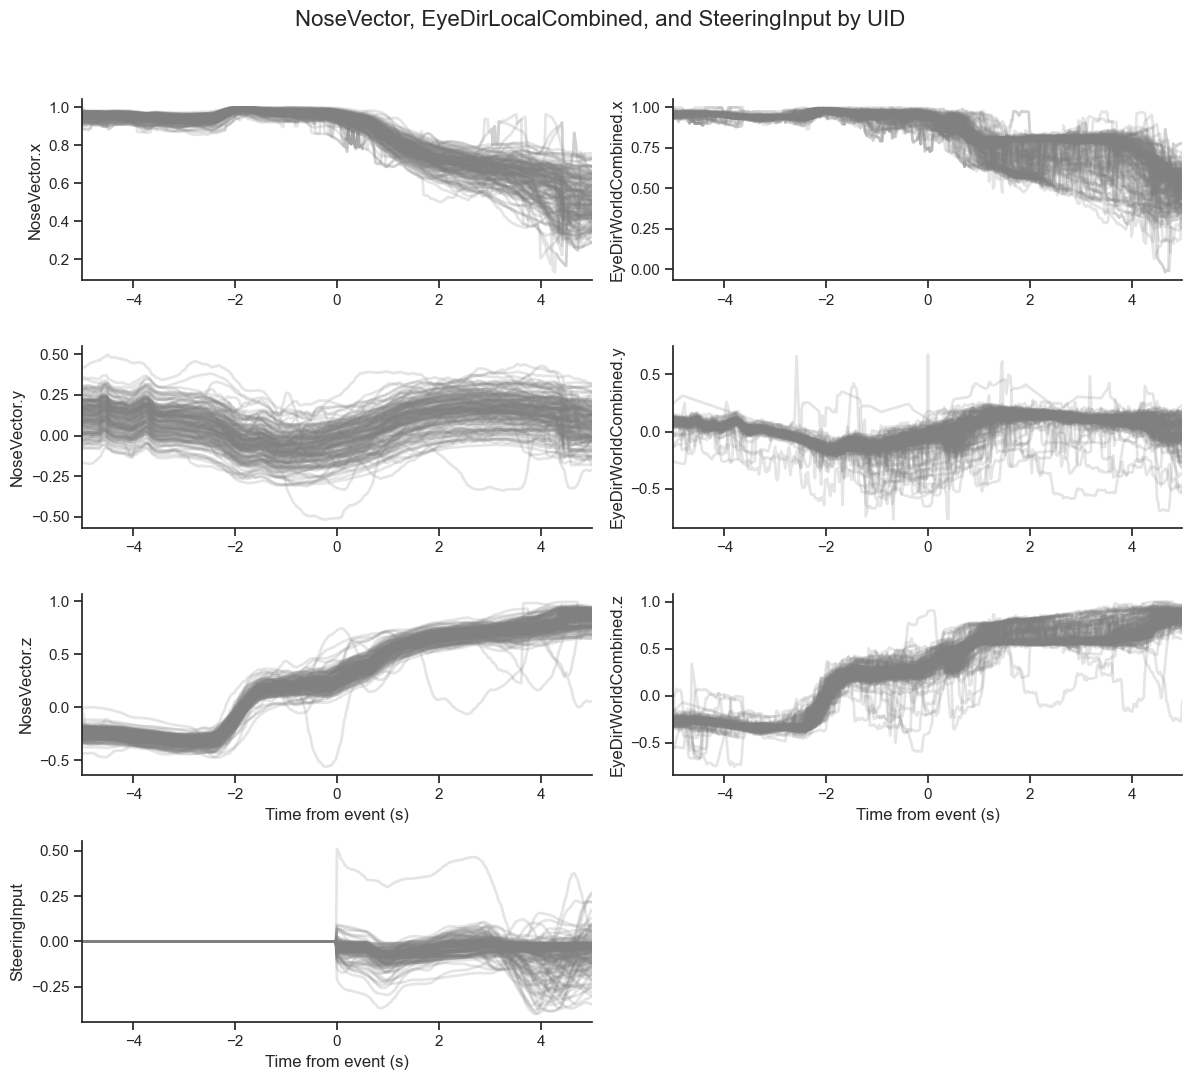

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns  # For despine

def plot_vectors(df, uid_col='uid'):
    """
    Plot NoseVector and EyeDirLocalCombined components in a 4x2 subplot figure,
    showing individual lines per uid,
    despined axes with white grid and x-limits set to time_from_event range.
    The last row's left subplot is reserved for SteeringInput.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the columns:
        ['uid', 'time_from_event',
         'NoseVector.x', 'NoseVector.y', 'NoseVector.z',
         'EyeDirLocalCombined.x', 'EyeDirLocalCombined.y', 'EyeDirLocalCombined.z',
         'SteeringInput']
    - uid_col (str): Column name representing unique identifiers (default 'uid').
    """

    fig, axs = plt.subplots(4, 2, figsize=(12, 11), sharex=False)
    fig.suptitle("NoseVector, EyeDirLocalCombined, and SteeringInput by UID", fontsize=16)

    unique_uids = df[uid_col].unique()

    left_cols = ['NoseVector.x', 'NoseVector.y', 'NoseVector.z']
    right_cols = ['EyeDirWorldCombined.x', 'EyeDirWorldCombined.y', 'EyeDirWorldCombined.z']

    color = 'gray'
    alpha = 0.2
    linewidth = 2

    x_min = df['time_from_event'].min()
    x_max = df['time_from_event'].max()

    # Plot NoseVector and EyeDirLocalCombined (top 3 rows)
    for uid in unique_uids:
        df_uid = df[df[uid_col] == uid].sort_values('time_from_event')

        for i, col in enumerate(left_cols):
            axs[i, 0].plot(df_uid['time_from_event'], df_uid[col],
                           color=color, alpha=alpha, linewidth=linewidth)

        for i, col in enumerate(right_cols):
            axs[i, 1].plot(df_uid['time_from_event'], df_uid[col],
                           color=color, alpha=alpha, linewidth=linewidth)

        # SteeringInput in last row, left column only
        axs[3, 0].plot(df_uid['time_from_event'], df_uid['SteeringInput'],
                       color=color, alpha=alpha, linewidth=linewidth)

    # Set labels, limits, grids, and despine for upper 3 rows
    for i, col in enumerate(left_cols):
        ax = axs[i, 0]
        ax.set_ylabel(col)
        ax.set_xlim(x_min, x_max)
        # ax.grid(True, color='white', linestyle='-', linewidth=2, alpha=1)
        sns.despine(ax=ax, top=True, right=True)

    for i, col in enumerate(right_cols):
        ax = axs[i, 1]
        ax.set_ylabel(col)
        ax.set_xlim(x_min, x_max)
        # ax.grid(True, color='white', linestyle='-', linewidth=1, alpha=0.7)
        sns.despine(ax=ax, top=True, right=True)

    # SteeringInput axis formatting (last row, left column)
    ax_steering = axs[3, 0]
    ax_steering.set_ylabel('SteeringInput')
    ax_steering.set_xlabel('Time from event (s)')
    ax_steering.set_xlim(x_min, x_max)
    ax_steering.grid(True, color='white', linestyle='-', linewidth=2, alpha=1)
    sns.despine(ax=ax_steering, top=True, right=True)

    # Turn off unused subplot (last row, right column)
    axs[3, 1].axis('off')

    # Set x-labels for last row in left column (done above) and also for upper right col (optional)
    for ax in axs[2, :]:
        ax.set_xlabel('Time from event (s)')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage:
plot_vectors(df_single_event, uid_col='uid')

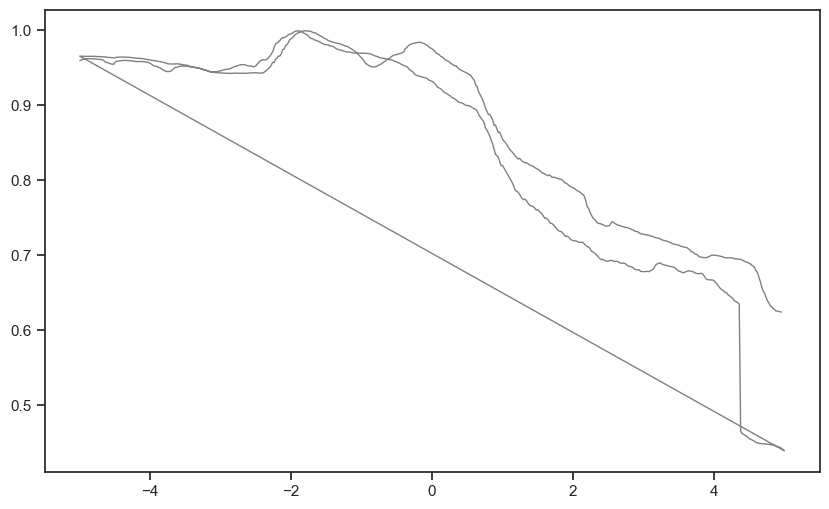

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)

plt.plot(df_single_event['time_from_event'].head(1000), df_single_event['NoseVector.x'].head(1000), label='NoseVector.x', color='gray', alpha=1, linewidth=1)


In [10]:
time_point = df_single_event[df_single_event['time_from_event']==-0.2][['NoseVector.x','EyeDirWorldCombined.x','uid','ExperimentalCondition']]
# time_point.to_csv(f"data/sample_time_negative_2s_stagEventNew.csv", index=False)
time_point.reset_index(drop=True, inplace=True)
time_point

,NoseVector.x,EyeDirWorldCombined.x,uid,ExperimentalCondition
0,0.939252,0.957435,0037b2329de444c18d751b4e79901b39,BaseCondition
1,0.983775,0.961836,0117810eb9634c4f98f842021ee6a595,FullLoopAR
2,0.972688,0.963825,0121f5b2f59d434f8beb17bf3e2a80b9,BaseCondition
3,0.969374,0.960688,0956f0cca5f546d79a0cf4fbae23d496,FullLoopAR
4,0.992968,0.978600,09a23914cf354ea39444511406d16722,BaseCondition
...,...,...,...,...
155,0.954555,0.954151,f9c6ff61370141c89ea9bbc536d796e1,FullLoopAR
156,0.977008,0.805922,fa2e2604ec6a4820851f032e80f09ba1,AudioOnly
157,0.959494,0.970303,fa4ca90c5b80445b9af0b7ec4fbcc124,BaseCondition
158,0.939381,0.976166,fd19a21a4a8846ca82bd127e4e1933f5,BaseCondition


In [ ]:
# exclude_list = ['bb85c212fe8842ec95b8e3dea2c524b0','c141c1065c1b45a9bffe0a89a7032662']
# new_df = df_single_event#[~df_single_event['uid'].isin(exclude_list)]
# new_df

In [ ]:
# fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)

# sns.lineplot(data=new_df, x='time_from_event', y='NoseVector.x',label='NoseVector.x', color='blue', alpha=0.5, linewidth=1, ax=axs, legend=False)
# sns.lineplot(data=new_df, x='time_from_event', y='EyeDirWorldCombined.x', label='EyeDirWorldCombined.x',color='gray', alpha=0.5, linewidth=1, ax=axs, legend=True)

In [ ]:
# new_df = time_point[~time_point['uid'].isin(exclude_list)]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
sns.scatterplot(data=time_point, x='NoseVector.x', y='EyeDirWorldCombined.x')

# Apply PCA

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
import dask.array as da
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
import gc
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
plt.style.use('ggplot')

In [11]:
time_point[['NoseVector.x','EyeDirWorldCombined.x']]

,NoseVector.x,EyeDirWorldCombined.x
0,0.939252,0.957435
1,0.983775,0.961836
2,0.972688,0.963825
3,0.969374,0.960688
4,0.992968,0.978600
...,...,...
155,0.954555,0.954151
156,0.977008,0.805922
157,0.959494,0.970303
158,0.939381,0.976166


In [12]:
scaler = StandardScaler(with_std=True)
subset_scaled = scaler.fit_transform(time_point[['NoseVector.x','EyeDirWorldCombined.x']])
df_i = pd.DataFrame(subset_scaled)
df_i

,0,1
0,-1.152661,0.286537
1,0.942015,0.420723
2,0.420386,0.481351
3,0.264470,0.385705
4,1.374489,0.931803
...,...,...
155,-0.432718,0.186404
156,0.623624,-4.332810
157,-0.200352,0.678864
158,-1.146602,0.857593


<Axes: xlabel='0', ylabel='1'>

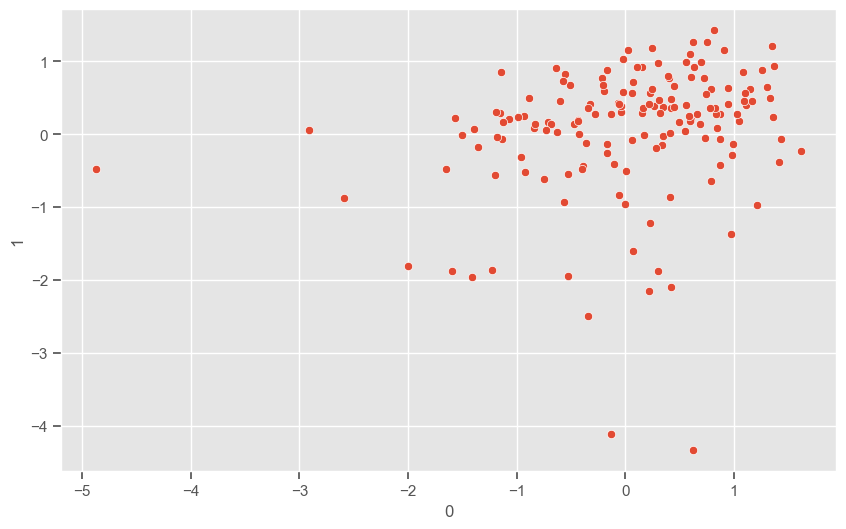

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
sns.scatterplot(data=df_i, x=0,y=1)


In [14]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import dask.array as da
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
import gc

In [15]:
# Simple mahalanobis distance
def mahalanobis(df, no_dask=True, md_name='',outlier_name=''):
    # Calculate mean
    x_minus_mu = df - np.mean(df)
    # Calculate covariance
    cov = np.cov(df.values.T)
    # Calculate inverse covariance
    if df.shape[1] < 2:
        # Reshape when only one column in used (e.g., 'SteeringInput')
        inv_covmat = sp.linalg.inv(cov.reshape((1,1)))
    else:
        inv_covmat = sp.linalg.inv(cov)
    if no_dask:
        # No dask work only for individual UID
        left_term = np.dot(x_minus_mu, inv_covmat)
        mahal = np.dot(left_term, x_minus_mu.T)
        # Calculate md
        md = np.sqrt(mahal.diagonal())
    else:
        # Dask needs to be used when calculating md across conditions
        x_minus_mu_dask = da.from_array(x_minus_mu.to_numpy(), chunks=(min(x_minus_mu.shape[0], 10000), df.shape[1]))
        mahal = np.sqrt(np.diagonal(np.dot(np.dot(x_minus_mu_dask,inv_covmat), x_minus_mu_dask.T)))
        # Calculate md
        md = mahal.compute()
    # Save md values to df column
    md_df = pd.DataFrame({md_name:md})
    # Set a cut-off threshold based on the Chi2 and the degrees of freedom
    # Here we choose to be conservative and only get very extreme outliers
    threshold = chi2.ppf((1-0.001), df=df.shape[1])  # degrees of freedom = number of variables
    # Assuming 'mahalanobis_distances' contains your computed distances
    # mean_md = np.mean(md)
    # std_md = np.std(md)
    # threshold_5std = mean_md + 3 * std_md
    # Set as outliers md > threshold
    md_df[outlier_name] = md_df[md_name] > threshold
    # if md_name == 'md_car':
    #     print(C)
    return md_df

In [16]:
### Robust Mahalonibis Distance
def robust_mahalanobis_method_dask(df, md_name='',outlier_name='', p_md_name='', cut=0.001):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)

    # Calculate inverse covariance
    if df.shape[1] < 2:
        # Reshape when only one column in used (e.g., 'SteeringInput')
        # X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov.reshape((1,1)), size= round(len(df) * 0.5))
        cov = MinCovDet(random_state=0).fit(df) #calculate covariance
        mcd = cov.covariance_ #robust covariance metric
        robust_mean = cov.location_  #robust mean
        inv_covmat = sp.linalg.inv(mcd) #inverse of covariance matrix
    else:
        X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size= round(len(df) * 0.5))
        cov = MinCovDet(random_state=0).fit(X) #calculate covariance
        mcd = cov.covariance_ #robust covariance metric
        robust_mean = cov.location_  #robust mean
        inv_covmat = sp.linalg.inv(mcd) #inverse of covariance matrix

    # Robust M-Distance
    x_minus_mu = df - robust_mean
    print(x_minus_mu)
    # Transform data into dask arrays
    x_minus_mu_dask = da.from_array(x_minus_mu.to_numpy(), chunks=(min(x_minus_mu.shape[0], 10000), df.shape[1]))
    mahal = da.sqrt(da.diagonal(da.dot(da.dot(x_minus_mu_dask,inv_covmat), x_minus_mu_dask.T)))
    # Calculate md
    md = mahal.compute()
    # Compute the chi-squared cumulative probability distribution to transfer the md2 into probabilities
    probability_md = 1 - chi2.cdf(md, df=df.shape[1])

    # Save md values and probabilities to df column
    md_df = pd.DataFrame({md_name:md,p_md_name:probability_md})
    # Set a Chi2 cut-off point using probability of 0.01 (99.5% Chi2 quantile)
    # Degrees of freedom (df) = number of variables
    threshold = chi2.ppf((1-cut), df=df.shape[1]-1)
    print(threshold)
    # STD threshold, assuming 'md' contains your computed distances
    # mean_md = np.mean(md)
    # std_md = np.std(md)
    # threshold_3std = mean_md + 4 * std_md
    # Flag outliers as md > threshold
    md_df[outlier_name] = md_df[md_name] > threshold
    return md_df

In [17]:
def mahalanobis_per_condition(df, cut=0.001):
    # Select unique uids
    conditions = df['ExperimentalCondition'].unique()

    # Empty df to save all md and outliers
    md_df = pd.DataFrame()

    # for i, condition in enumerate(conditions):
        # Select the uid data subset
        # df_uid = df[df['ExperimentalCondition'].isin([condition])].reset_index(drop=True)
        # print(df_uid)
        ## ---- EYE columns ----
        # mahalanobis distances for each data subset
    mds_eye= robust_mahalanobis_method_dask(df=df[['NoseVector.x','EyeDirWorldCombined.x']], md_name='md_eye',outlier_name='eye_outlier',p_md_name='p_md_head', cut=cut).reset_index(drop=True)

        ## ---- HEAD columns ----
        # mds_head= robust_mahalanobis_method_dask(df=df_uid[['RelativeHeadYaw_degrees','RelativeHeadPitch_degrees', 'RelativeHeadRoll_degrees']], md_name='md_head_condition',outlier_name='head_outlier_condition', p_md_name='p_md_head_condition', cut=0.001).reset_index(drop=True)
        #
        # ## ---- CAR columns ----
        # mds_car= robust_mahalanobis_method_dask(df=df_uid[['CarYaw_degrees', 'CarPitch_degrees', 'CarRoll_degrees']], md_name='md_car_condition',outlier_name='car_outlier_condition', p_md_name='p_md_car_condition', cut=0.001).reset_index(drop=True)
        #
        # ## ---- Steering ----
        # mds_steer= robust_mahalanobis_method_dask(df=df_uid[['streeringDegree']], md_name='md_steering_condition',outlier_name='steering_outlier_condition', p_md_name='p_md_steer_condition', cut=0.001).reset_index(drop=True)
        #
        # ## ---- Pupil dilation ----
        # mds_pupil= robust_mahalanobis_method_dask(df=df_uid[['Pupil_Dilation_mean']], md_name='md_pupil_dilation_condition',outlier_name='pupil_dilation_outlier_condition', p_md_name='p_md_pupil_condition', cut=0.001).reset_index(drop=True)

        ## save md and outlier data
        # md_df = pd.concat([md_df, pd.concat([mds_eye,mds_head,mds_car,mds_steer,mds_pupil], axis=1)], ignore_index=True)
        # md_df = pd.concat([md_df, pd.concat([mds_eye], axis=1)], ignore_index=True)
    ## Concatenate original df with calculated mahalanobis distances and outliers
    # df = pd.concat([df.reset_index(drop=True), mds_eye.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), mds_eye.reset_index(drop=True)], axis=1)
    return df

In [18]:
import numpy as np
import pandas as pd
import dask.array as da
import scipy.linalg as sp_linalg
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_confidence_ellipse(ax, mean, cov, confidence=0.95, facecolor='none', edgecolor='red', **kwargs):
    """
    Plot a confidence ellipse based on the mean and covariance.
    confidence: float - e.g. 0.95 for 95% ellipse
    ax: matplotlib axis
    mean: array-like [2]
    cov: 2x2 covariance matrix
    """
    # Compute the quantile of the chi-squared distribution for given confidence and 2 degrees of freedom
    chi2_val = chi2.ppf(confidence, df=2)

    # Get eigenvalues and eigenvectors of covariance matrix
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # Calculate width and height of ellipse (2 * sqrt(eigenvalues * chi2 quantile))
    width, height = 2 * np.sqrt(vals * chi2_val)

    # Calculate angle of ellipse rotation in degrees
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      facecolor=facecolor, edgecolor=edgecolor, lw=2, **kwargs)

    ax.add_patch(ellipse)
    return ellipse

def robust_mahalanobis_method_dask2(df, md_name='md', outlier_name='outlier', p_md_name='p_md', cut=0.001):
    # Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)

    # Calculate inverse covariance robustly
    # if df.shape[1] < 2:
    #     cov = MinCovDet(random_state=0).fit(df.values.reshape(-1,1))
    #     mcd = cov.covariance_
    #     robust_mean = cov.location_
    #     inv_covmat = sp_linalg.inv(mcd)
    # else:
    # X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size= round(len(df) * 0.5))
    cov = MinCovDet(random_state=0).fit(df.values)
    mcd = cov.covariance_
    robust_mean = cov.location_
    inv_covmat = sp_linalg.inv(mcd)

    # Calculate robust Mahalanobis distances
    x_minus_mu = df.values - robust_mean
    x_minus_mu_dask = da.from_array(x_minus_mu, chunks=(min(x_minus_mu.shape[0], 10000), df.shape[1]))
    mahal_sq = da.diagonal(x_minus_mu_dask @ inv_covmat @ x_minus_mu_dask.T)
    md = da.sqrt(mahal_sq).compute()

    # Calculate probability using Chi2 distribution
    p_md = 1 - chi2.cdf(mahal_sq.compute(), df=df.shape[1])

    # Threshold
    threshold = chi2.ppf(1 - cut, df=df.shape[1])

    # Compile result DataFrame
    md_df = pd.DataFrame({
        md_name: md,
        p_md_name: p_md
    })
    md_df[outlier_name] = mahal_sq.compute() > threshold

    # Visualization (only for 2D data)
    if df.shape[1] == 2:
        fig, ax = plt.subplots(figsize=(8,6))
        # Plot original points, color by outlier flag
        colors = np.where(md_df[outlier_name], 'red', 'blue')
        ax.scatter(df.iloc[:,0], df.iloc[:,1], c=colors, label='Data points')

        # Plot robust mean
        ax.scatter(robust_mean[0], robust_mean[1], color='green', marker='x', s=100, label='Robust Mean')

        # Plot confidence ellipses for multiple levels
        confidence_levels = [1-cut]
        for conf in confidence_levels:
            plot_confidence_ellipse(ax, robust_mean, mcd, confidence=conf, edgecolor='orange', alpha=0.5, linestyle='--')

        ax.set_title('Robust Mahalanobis Distance with Confidence Ellipses')
        ax.set_xlabel(df.columns[0])
        ax.set_ylabel(df.columns[1])
        ax.legend()
        plt.grid(True)
        plt.show()

    return md_df

In [19]:
time_point

,NoseVector.x,EyeDirWorldCombined.x,uid,ExperimentalCondition
0,0.939252,0.957435,0037b2329de444c18d751b4e79901b39,BaseCondition
1,0.983775,0.961836,0117810eb9634c4f98f842021ee6a595,FullLoopAR
2,0.972688,0.963825,0121f5b2f59d434f8beb17bf3e2a80b9,BaseCondition
3,0.969374,0.960688,0956f0cca5f546d79a0cf4fbae23d496,FullLoopAR
4,0.992968,0.978600,09a23914cf354ea39444511406d16722,BaseCondition
...,...,...,...,...
155,0.954555,0.954151,f9c6ff61370141c89ea9bbc536d796e1,FullLoopAR
156,0.977008,0.805922,fa2e2604ec6a4820851f032e80f09ba1,AudioOnly
157,0.959494,0.970303,fa4ca90c5b80445b9af0b7ec4fbcc124,BaseCondition
158,0.939381,0.976166,fd19a21a4a8846ca82bd127e4e1933f5,BaseCondition


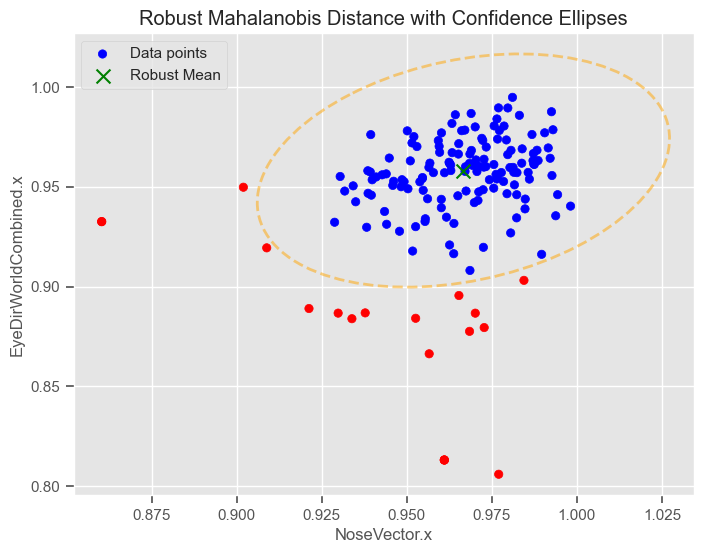

,md,p_md,outlier
0,1.732781,2.228479e-01,False
1,1.053081,5.743655e-01,False
2,0.458428,9.002543e-01,False
3,0.206176,9.789701e-01,False
4,1.844483,1.824901e-01,False
...,...,...,...
155,0.742130,7.592847e-01,False
156,10.269578,0.000000e+00,True
157,1.025451,5.910974e-01,False
158,2.360010,6.174000e-02,False


In [20]:
robust_mahalanobis_method_dask2(df=time_point[['NoseVector.x','EyeDirWorldCombined.x']], cut=0.001)

In [21]:
df_mah = mahalanobis_per_condition(df=time_point, cut=0.001)
df_mah

     NoseVector.x  EyeDirWorldCombined.x
0       -0.028476               0.009824
1        0.016047               0.014225
2        0.004960               0.016214
3        0.001646               0.013076
4        0.025239               0.030988
..            ...                    ...
155     -0.013173               0.006539
156      0.009279              -0.141690
157     -0.008234               0.022692
158     -0.028347               0.028554
159     -0.011165              -0.081304

[160 rows x 2 columns]
10.827566170662733


,NoseVector.x,EyeDirWorldCombined.x,uid,ExperimentalCondition,md_eye,p_md_head,eye_outlier
0,0.939252,0.957435,0037b2329de444c18d751b4e79901b39,BaseCondition,1.476283,0.478001,False
1,0.983775,0.961836,0117810eb9634c4f98f842021ee6a595,FullLoopAR,0.822372,0.662864,False
2,0.972688,0.963825,0121f5b2f59d434f8beb17bf3e2a80b9,BaseCondition,0.497250,0.779872,False
3,0.969374,0.960688,0956f0cca5f546d79a0cf4fbae23d496,FullLoopAR,0.380835,0.826614,False
4,0.992968,0.978600,09a23914cf354ea39444511406d16722,BaseCondition,1.400645,0.496425,False
...,...,...,...,...,...,...,...
155,0.954555,0.954151,f9c6ff61370141c89ea9bbc536d796e1,FullLoopAR,0.706799,0.702296,False
156,0.977008,0.805922,fa2e2604ec6a4820851f032e80f09ba1,AudioOnly,4.299458,0.116516,False
157,0.959494,0.970303,fa4ca90c5b80445b9af0b7ec4fbcc124,BaseCondition,0.843801,0.655799,False
158,0.939381,0.976166,fd19a21a4a8846ca82bd127e4e1933f5,BaseCondition,1.751945,0.416457,False


<Axes: xlabel='NoseVector.x', ylabel='EyeDirWorldCombined.x'>

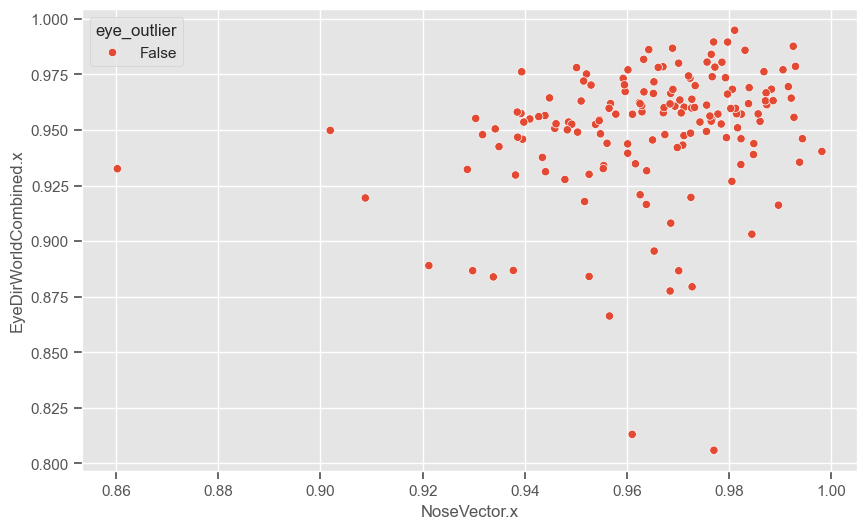

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(data=df_mah, x='NoseVector.x', y='EyeDirWorldCombined.x',hue= 'eye_outlier')

In [23]:
np.array(time_point[['NoseVector.x', 'EyeDirWorldCombined.x']])

array([[0.93925241, 0.95743515],
       [0.98377526, 0.9618364 ],
       [0.9726879 , 0.96382499],
       [0.96937388, 0.96068782],
       [0.99296761, 0.97859973],
       [0.95924932, 0.97317529],
       [0.95543629, 0.93398917],
       [0.95382741, 0.9525131 ],
       [0.99267352, 0.95566607],
       [0.90192515, 0.94979   ],
       [0.99052644, 0.97707474],
       [0.95012885, 0.97803938],
       [0.99157196, 0.96948388],
       [0.95258442, 0.88409844],
       [0.93817604, 0.92972398],
       [0.9624052 , 0.96230346],
       [0.99813834, 0.94032937],
       [0.95780671, 0.95710742],
       [0.98230934, 0.94604832],
       [0.97250634, 0.91966885],
       [0.95609048, 0.94400203],
       [0.9822787 , 0.93443495],
       [0.96710122, 0.95773911],
       [0.93384022, 0.88389456],
       [0.98963374, 0.91615576],
       [0.96012717, 0.94372672],
       [0.93955684, 0.94581872],
       [0.97116411, 0.9602564 ],
       [0.97554541, 0.94933307],
       [0.96704459, 0.97842431],
       [0.

In [24]:
from sklearn.covariance import EllipticEnvelope
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import OneClassSVM

estimators = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.0, contamination=0.01),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(
        contamination=0.01
    ),
    "OCSVM": OneClassSVM(nu=0.01, gamma=0.35),
}

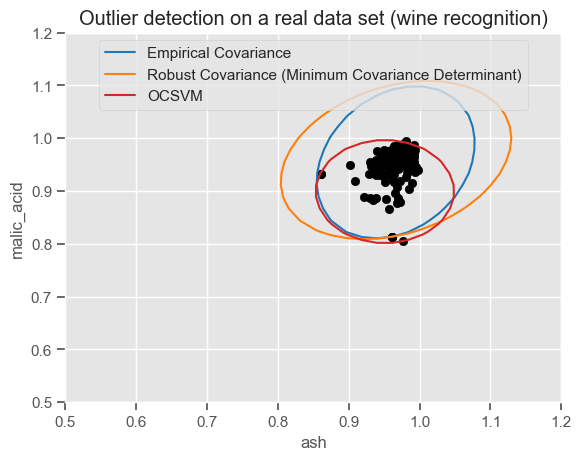

In [25]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine

# X = load_wine()["data"][:, [1, 2]]  # two clusters

X = np.array(time_point[['NoseVector.x', 'EyeDirWorldCombined.x']])

fig, ax = plt.subplots()
colors = ["tab:blue", "tab:orange", "tab:red"]
# Learn a frontier for outlier detection with several classifiers
legend_lines = []
for color, (name, estimator) in zip(colors, estimators.items()):
    estimator.fit(X)
    DecisionBoundaryDisplay.from_estimator(
        estimator,
        X,
        response_method="decision_function",
        plot_method="contour",
        levels=[0],
        colors=color,
        ax=ax,
    )
    legend_lines.append(mlines.Line2D([], [], color=color, label=name))


ax.scatter(X[:, 0], X[:, 1], color="black")
ax.set_xlim(0.5,1.2)
ax.set_ylim(0.5,1.2)
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
ax.annotate(
    "outlying points",
    xy=(4, 2),
    xycoords="data",
    textcoords="data",
    xytext=(3, 1.25),
    bbox=bbox_args,
    arrowprops=arrow_args,
)
ax.legend(handles=legend_lines, loc="upper center")
_ = ax.set(
    xlabel="ash",
    ylabel="malic_acid",
    title="Outlier detection on a real data set (wine recognition)",
)

In [26]:
X

array([[0.93925241, 0.95743515],
       [0.98377526, 0.9618364 ],
       [0.9726879 , 0.96382499],
       [0.96937388, 0.96068782],
       [0.99296761, 0.97859973],
       [0.95924932, 0.97317529],
       [0.95543629, 0.93398917],
       [0.95382741, 0.9525131 ],
       [0.99267352, 0.95566607],
       [0.90192515, 0.94979   ],
       [0.99052644, 0.97707474],
       [0.95012885, 0.97803938],
       [0.99157196, 0.96948388],
       [0.95258442, 0.88409844],
       [0.93817604, 0.92972398],
       [0.9624052 , 0.96230346],
       [0.99813834, 0.94032937],
       [0.95780671, 0.95710742],
       [0.98230934, 0.94604832],
       [0.97250634, 0.91966885],
       [0.95609048, 0.94400203],
       [0.9822787 , 0.93443495],
       [0.96710122, 0.95773911],
       [0.93384022, 0.88389456],
       [0.98963374, 0.91615576],
       [0.96012717, 0.94372672],
       [0.93955684, 0.94581872],
       [0.97116411, 0.9602564 ],
       [0.97554541, 0.94933307],
       [0.96704459, 0.97842431],
       [0.

In [27]:
# Map each condition to a float number
# label_mapping = {'True': 1, 'False': 0}
# # with outliers
# df_single_event.loc[:,'SuccessfulCompletion'] = df_single_event['SuccessfulCompletionState'].map(label_mapping)
# df_single_event

## Useful functions

In [28]:
# Mapping of old labels to new labels
def map_labels(labels, label_mapping):
    """
    Maps each label in the given list using the provided mapping dictionary.

    Args:
        labels (list): List of original labels.
        label_mapping (dict): Mapping dictionary for label replacement.

    Returns:
        list: New list with mapped labels.
    """
    return [label_mapping.get(label, label) for label in labels]

# Define your label mapping (you can modify this as needed)
custom_mapping = {
    'EyeDirWorldCombined.x': 'Eye Horizontal',
    'EyeDirWorldCombined.y': 'Eye Vertical',
    'NoseVector.x': 'Head Horizontal',
    'NoseVector.y': 'Head Vertical',
    'SteeringInput': 'Steering',
    'ExperimentalCondition ': 'Condition',
    'SuccessfulCompletionState': 'SuccessfulCompletion'
}

In [189]:
def biplot(score, coef, eigenvalues,
           labels=None,
           color_map=None,
           colors=None,
           explained_variance=None,
           vector_colors=None,
           scaled=None,
           vector_linewidth=None,
           legend_by='condition', # new parameter with default 'condition'
           **kwargs,):
    # plt.rcParams.update({'font.size': 10})
    # Apply 90-degree rotation matrix to `score` and `coef`
    rotation_matrix = np.array([[0, -1], [1, 0]])
    # Rotate the first two components of the scores
    # score = np.dot(score[:, :2], rotation_matrix)
    # Rotate the first two components of the loadings
    # coef = np.dot(coef[:, :2], rotation_matrix)
    xs = score[:, 0]
    ys = score[:, 1]
    n = coef.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    padding= 1.2 # 20% padding for axis and vector scaling
    padding_text = 1 # 10 % padding for text
    xlims = padding * np.max(np.abs(xs))
    ylims = padding * np.max(np.abs(ys))
    if colors is None:  # If no color information, plot all points orange
        plt.scatter(xs, ys, s=80, color='gray', alpha=0.5,edgecolor='gray')
        # plt.scatter(xs, ys, s=80, color='orange')
    else:  # If color information is given, plot points with corresponding colors
        # plt.scatter(xs * scalex, ys * scaley, s=80, color=colors, alpha=0.5)
        plt.scatter(xs, ys, s=80, color=colors, alpha=0.5,edgecolor=colors)
    plt.xlim(-xlims * padding,xlims * padding)
    plt.ylim(-ylims* padding,ylims* padding)

    # Adjust the number of labels to match the number of coefficients
    original_labels = labels[:n]

    # Call the function to get the new mapped labels
    labels = map_labels(original_labels, custom_mapping)

    # Draw principal component vectors as arrows
    for i in range(n):
        # Calculate arrow end point (arrow head)
        arrow_end_x = xlims * coef[i, 0]
        arrow_end_y = ylims * coef[i, 1]
        if scaled:
            # Draw the arrow starting from the origin (0, 0) to the arrow head
            plt.arrow(0, 0, arrow_end_x, arrow_end_y, color=vector_colors[i], alpha=1, linewidth=vector_linewidth,length_includes_head=True,head_length=0.1,head_width=0.1,overhang=0)
        else:
            plt.arrow(0, 0, arrow_end_x, arrow_end_y, color=vector_colors[i], alpha=1, linewidth=vector_linewidth,length_includes_head=True,head_length=0.7,head_width=0.7,overhang=0)
    # Position the label above the arrow head
        if labels is not None:
            if arrow_end_y > 0:
                va='bottom'
            else:
                va='top'
            # Annotate the point with text (you can customize the text as needed)
            plt.text(arrow_end_x * padding_text, arrow_end_y * padding_text,
                     f"{labels[i]}\n({coef[i, 0]:.2f}, {coef[i, 1]:.2f})",color='black',ha='center', va=va,fontdict=dict(fontsize=14), bbox=dict(facecolor='white', alpha=0.0001, edgecolor='white'))
    # Write first two eigenvalues
    # plt.text(-ylims + padding_text, -xlims * padding_text, "Eigenvalues:\n {:.2f}, {:.2f}".format(*eigenvalues),ha='left', va='bottom', fontsize=10)
    # Write all eigenvalues
    # plt.text(-ylims + 0.5, -xlims + 0.5, "Eigenvalues:\n " + ", ".join(f"{val:.2f}" for val in eigenvalues), ha='left', va='bottom', fontsize=10)

    # Set fixed axis limits
    ax = plt.gca()
    fixed_x_min, fixed_x_max = -xlims, xlims  # Your specified x limits
    fixed_y_min, fixed_y_max = -ylims, ylims  # Your specified y limits

    # Set the fixed limits
    plt.xlim(fixed_x_min, fixed_x_max)
    plt.ylim(fixed_y_min, fixed_y_max)

    # Hide all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Parameters for arrows
    arrow_length = 0.15  # Size of the arrowhead
    arrow_linewidth = 2.5

    # Create y-axis arrow (vertical) ON THE LEFT SPINE
    #  Start at bottom left corner
    ax.arrow(fixed_x_min +arrow_length, fixed_y_min+arrow_length,
             0, fixed_y_max - (fixed_y_max/2.5),  # Go up to max - arrowhead space
             head_width=arrow_length, head_length=arrow_length,
             fc='black', ec='black', linewidth=arrow_linewidth,
             length_includes_head=True)

    # Create x-axis arrow (horizontal) ON THE BOTTOM SPINE
    # Start at bottom left corner
    ax.arrow(fixed_x_min +arrow_length, fixed_y_min+arrow_length,
             fixed_x_max - (fixed_x_max/2.5), 0,  # Go right to max - arrowhead space
             head_width=arrow_length, head_length=arrow_length,
             fc='black', ec='black', linewidth=arrow_linewidth,
             length_includes_head=True)
    # Hide tick parameters
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove standard labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add custom positioned labels
    # X-axis label - at the start of the x-axis arrow
    ax.text(fixed_x_min + 1.5, fixed_y_min - 0.1,  # Position just below the arrow end
            "PC{} ({:.1f}%)".format(1, explained_variance[0] * 100),
            fontsize=10, ha='right', va='top')

    # Y-axis label - at the start of the y-axis arrow
    ax.text(fixed_x_min + 0.02, fixed_y_min + 0.6,  # Position to the left of arrow end
            "PC{} ({:.1f}%)".format(2, explained_variance[1] * 100),
            fontsize=10, ha='right', va='bottom', rotation=90)

    # Add a legend for the colors if provided
    # Create a mapping from condition to color
    # Add a legend for the condition labels based on their colors
    # Automatic legend based on color_map
    # Generate legend based on specified criteria
    if colors is not None:
        import collections
        handles = []

        if legend_by == 'condition' and color_map is not None:
            # Build reverse map from color to condition
            color_to_condition = {v: k for k, v in color_map.items()}
            unique_colors = list({c for c in colors})
            for col in unique_colors:
                label = color_to_condition.get(col, col)
                handle = Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=col, markersize=10,
                                label=label)
                handles.append(handle)
            plt.legend(handles=handles, title = legend_by.capitalize(), fontsize=10, title_fontsize= 12, loc='upper right')


        elif legend_by == 'completion':
            # Based on 'SuccessfulCompletionState' column
            # Create a mapping for completion status if not provided
            # Assign green for success (==1), red otherwise
            for cond_value in set(kwargs.get('completion_states', [])):
                if cond_value == 0:
                    col = 'red'
                    label = 'Failure'
                elif cond_value == 1:
                    col = 'green'
                    label = 'Success'
                handle = Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=col, markersize=10,
                                label=label)
                handles.append(handle)
            plt.legend(handles=handles,title = legend_by.capitalize(), fontsize=10, title_fontsize= 12, loc='upper right')
            # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize=10)
    # plt.tight_layout()

In [181]:
def get_pca_var(pca, subset_scaled, feature_names):
    # Validate input types
    if not isinstance(pca, PCA):
        raise TypeError("Expected a PCA object from sklearn.decomposition.PCA")

    # Compute coordinates
    coords = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Compute correlations
    # Since we're using standardized data:
    cor = coords / np.std(subset_scaled, axis=0)

    # Compute cos2 (squared loadings or cosine similarity)
    cos2 = np.square(cor)

    # Compute contributions
    total_variance = np.sum(pca.explained_variance_)
    contrib = (cos2 * 100 * pca.explained_variance_) / total_variance

    # Create dataframes with feature names as the index
    coord_df = pd.DataFrame(coords, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    cor_df = pd.DataFrame(cor, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    cos2_df = pd.DataFrame(cos2, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    contrib_df = pd.DataFrame(contrib, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

    return {
        'coord': coord_df,
        'cor': cor_df,
        'cos2': cos2_df,
        'contrib': contrib_df
    }

In [182]:
from matplotlib.patches import Circle
from matplotlib import colors as mcolors

def plot_cosine_similarity(cos2_df, title='', time_point='', save=False):
    # Extract feature names directly from the DataFrame index
    feature_names = cos2_df.index

    # max_cos2_value = 1
    # print(f'Plotting cosine similarity...')
    max_cos2_value = cos2_df.values.max() # color bar maximum limit
    # Create a custom colormap from white to #A2530E
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "#A2530E"])

    features, components = cos2_df.shape
    fig, ax = plt.subplots(figsize=(8, 4))
    if len(feature_names) > 10:
        num_fontsize = 10
    num_fontsize = 12
    ax.set_title(title, fontsize=18)

    # Plot each circle and add annotations
    for i in range(features):
        for j in range(components):
            value = cos2_df.iloc[i, j]
            color = cmap(value / max_cos2_value)  # Normalize the color
            circle = Circle((j, i), radius=np.sqrt(value) * 0.5, color=color, fill=True)
            ax.add_artist(circle)

            # Annotate the cos2 value at the center of the circle
            ax.text(
                j, i, f'{value:.2f}',
                color='lightgray',
                ha='center', va='center',
                fontsize=num_fontsize,  # Adjust font size for readability
            )

    # Setup axis limits and labels
    ax.set_xlim(-0.5, components - 0.5)
    ax.set_ylim(-0.5, features - 0.5)
    ax.set_xticks(np.arange(components))
    ax.set_yticks(np.arange(features))
    ax.set_xticklabels([f'PC{i+1}' for i in range(components)], rotation=0)
    ax.set_yticklabels(feature_names)
    ax.set_aspect('equal', 'box')

    # Add grid lines for clarity
    ax.hlines(np.arange(-0.5, features), xmin=-0.5, xmax=components - 0.5, color='grey', lw=0.5)
    ax.vlines(np.arange(-0.5, components), ymin=-0.5, ymax=features - 0.5, color='grey', lw=0.5)

    # Set outer border to gray by modifying the spines
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')
        spine.set_linewidth(0.5)

    # Add a color bar on the right
    norm = mcolors.Normalize(vmin=0, vmax=max_cos2_value)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04, label='$Cos^2$')

    # Increase the number of ticks on the color bar for better granularity
    num_ticks = 6
    cbar.set_ticks(np.linspace(0, max_cos2_value, num_ticks))
    cbar.set_ticklabels([round(val, 2) for val in np.linspace(0, max_cos2_value, num_ticks)])
    cbar.outline.set_visible(True)
    plt.tight_layout()
    # if save:
    #     plt.savefig(f"plots/cosine/pca_cos2_{event}_{time_point}_{''.join(map(str, feature_names))}.pdf", dpi=1200)
    # plt.show()

In [183]:
from IPython.display import display, HTML
from celluloid import Camera

In [184]:
# Directories to save results
# Ensure os is imported to work with the file system
import os
from tqdm import tqdm  # Import the tqdm library for progress bar
import time  # Import time for simulating or handling elapsed time calculation

# Define the base results path
results_path = "data/pca_results"

# Create base results directory
os.makedirs(results_path, exist_ok=True)

# Create subdirectories under the base results path
directories = {
    "cleaned_new": os.path.join(results_path, "cleaned_new"),
    "variances": os.path.join(results_path, "variances"),
    "components": os.path.join(results_path, "components"),
    "eigenvalues": os.path.join(results_path, "eigenvalues"),
}

# Create each subdirectory
for subdir in directories.values():
    os.makedirs(subdir, exist_ok=True)

def visualize_event_pca(df, event='', time_point='', d_ts = 0, features='', scaled=True, vis_biplot=True,output_mode = 'show', legend_mode='condition',save_biplot=False, save_cos2_plot=False, save_cleaned=False, direc_path=''):
    if not event == '':
        df['EventName'] = df['EventName'].replace('NoEvent', event)
        event_df = df[df['EventName'] == event]
        if not time_point == '':
            if time_point == 'start':
                # event start time
                ts = event_df['time_from_event'].min()
            elif time_point == 'end':
                # event end time
                ts = event_df['time_from_event'].max()
            elif time_point == 'onset':
                # event end time
                ts = 0
            elif time_point == 'dynamic':
                ts = d_ts
            # timestamps = event_df['time'].unique()
            timestamps = event_df[np.isclose(event_df['time_from_event'], ts, atol=0.00001)]['time_from_event'].unique()
        else:
            # timestamp subset of the entire event
            timestamps = event_df['time_from_event'].unique()
    else:
        event = '_all_events_'
        # timestamp subset of the entire df
        timestamps = df['time_from_event'].unique()

    # DataFrames to save data
    df_cleaned_ts = pd.DataFrame()
    df_event_components = pd.DataFrame()
    df_event_variance = pd.DataFrame()
    df_pca_results = pd.DataFrame()
    df_sorted_eigenvalues = pd.DataFrame()  # To store sorted eigenvalues

    with (tqdm(total=len(timestamps), desc="Processing times", unit="", colour="green") as pbar):
        start_time = time.time()  # Store the starting time
        for i, timestamp in enumerate(timestamps):
            # Clear the previous plot before drawing the new one
            # ax.clear()
            # 0. Extract rows for this timestamp
            subset = df[df['time_from_event'] == timestamp]
            event_name = subset['EventName'].unique()[0]

            # 1. Update progress bar for the current timestamp
            pbar.set_postfix_str(f"Current Timestamp: {timestamp}")

            # 2. Clean outliers in subset
            subset_cleaned = subset#.pipe(clean_subset)

            # 3. Features
            subset_features1 = subset_cleaned[subset_cleaned.columns.intersection(features)]
            subset_features_renamed = subset_features1.rename(columns=custom_mapping)
            subset_features = subset_features_renamed.drop(columns=['ExperimentalCondition','SuccessfulCompletion'])
            original_labels = list(subset_features.columns)

            completion_states = list(subset['SuccessfulCompletionState'].unique())

            # 3.1 Colors
            if legend_mode == 'completion':
                color_map = {
                    1.0 : 'green',
                    0.0 : 'red',
                }
                colors = [color_map.get(condition, 'black') for condition in subset_features_renamed['SuccessfulCompletion']]
            else:
                color_map = {
                        'BaseCondition': 'gray',
                        'FullLoopAR': '#cc2936',
                        'HUDOnly': '#1f77b4',   # example blue
                        'AudioOnly': '#ff7f0e'  # example orange
                    }

                colors = [color_map.get(condition, 'black') for condition in subset_features_renamed['ExperimentalCondition']]

            # 4. Scaling
            if scaled:
                scaler = StandardScaler(with_std=True)
                subset_scaled = scaler.fit_transform(subset_features)
            else:
                subset_scaled = subset_features

            # 5. Perform PCA
            pca = PCA(whiten=True)#, svd_solver='full')
            pca_result = pca.fit_transform(subset_scaled)
            explained_variance = pca.explained_variance_ratio_
            eigenvalues = pca.explained_variance_

            # 5.1 Sorted eigenvalues
            sorted_eigenvalue_columns = [f'eigen_val{i+1}' for i in range(len(eigenvalues))]
            eigenvalues_df = pd.DataFrame([eigenvalues], columns=sorted_eigenvalue_columns)
            eigenvalues_df['Time'] = timestamp
            eigenvalues_df['EventName'] = event_name
            df_sorted_eigenvalues = pd.concat([df_sorted_eigenvalues, eigenvalues_df], ignore_index=True)

            # Save PCA results
            pca_result_df = pd.DataFrame(
                pca_result,
                columns=[f'PC{i+1}' for i in range(len(explained_variance))]
            )
            pca_result_df['Time'] = timestamp
            pca_result_df['EventName'] = event_name
            df_pca_results = pd.concat([df_pca_results, pca_result_df], ignore_index=True)

            # Components
            loadings = pd.DataFrame(
                pca.components_.T,
                columns=[f'PC{i+1}' for i, v in enumerate(explained_variance)],
            )
            loadings['Features'] = original_labels
            loadings['Time'] = timestamp
            loadings['EventName'] = event_name
            df_event_components = pd.concat([df_event_components, loadings], ignore_index=True)

            # Variance
            df_variances = pd.DataFrame(
                np.reshape(explained_variance, (1, len(explained_variance))),
                columns=[f'PC{i+1}' for i, v in enumerate(explained_variance)]
            )
            df_variances['Time'] = timestamp
            df_variances['EventName'] = event_name
            df_event_variance = pd.concat([df_event_variance, df_variances], ignore_index=True)

            # Visualization
            if vis_biplot:
                sns.set_theme(style="white")
                plt.figure(figsize=(8, 6))
                plt.title('Second: ' + str(timestamp), fontsize=22)
                biplot(
                    pca_result,
                    pca.components_.T,
                    eigenvalues,
                    original_labels,
                    color_map,
                    colors,
                    explained_variance,
                    vector_colors=['k'] * len(original_labels),
                    scaled=scaled,
                    vector_linewidth=1.1,
                    legend_by=legend_mode,
                    completion_states=completion_states
                )
                # --- Display or save biplot ---
                if output_mode == 'save':
                    if save_biplot:
                        save_path = f"plots/biplot/pca_{event}_{timestamp}_{''.join(map(str, original_labels))}.png"
                        os.makedirs(os.path.dirname(save_path), exist_ok=True)
                        plt.savefig(save_path, dpi=1200)
                        # print(f"Biplot saved to {save_path}")
                    plt.close() # Always close in save mode
                elif output_mode == 'show':
                    plt.show() # Show the plot and wait for user to close it
                else:
                    plt.close() # Default action is to close to prevent memory leaks
                    # print("Biplot created, saved, and closed.")

            # --- Block for Cosine Similarity Plot ---
            # plt.figure(figsize=(8, 4)) # Creates Figure B, makes it active
            # plt.close()
            pca_cos2 = get_pca_var(pca, subset_scaled, original_labels)
            cos2_matrix = pca_cos2['cos2']
            plot_cosine_similarity(cos2_matrix, title='Cosine Similarity ($Cos^2$)') # Plots on Figure B

            # --- Display or save cosine plot ---
            if output_mode == 'save':
                if save_cos2_plot:
                    save_path = f"plots/cosine/pca_cos2_{event}_{timestamp}_{''.join(map(str, original_labels))}.png"
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    plt.savefig(save_path, dpi=1200)
                    # print(f"Cosine similarity plot saved to {save_path}")
                plt.close() # Always close in save mode
            elif output_mode == 'show':
                plt.show() # Show the plot
            else:
                plt.close() # Default action is to close
                # print("Cosine plot created and closed.")
            plt.close()
            # finally, capture this frame
            # camera.snap()

            # Cleaned subset
            if save_cleaned:
                subset_features_renamed['EventName'] = event_name
                subset_features_renamed['Time'] = timestamp
                df_cleaned_ts = pd.concat([df_cleaned_ts, subset_features_renamed], ignore_index=True)

            # Update progress bar and elapsed time
            elapsed_time = time.time() - start_time
            pbar.update(1)
            pbar.set_postfix_str(f"Elapsed: {elapsed_time:.2f}s")

    # Save results
    if save_cleaned:
        if len(timestamps) > 1:
            timestamp = 'all'
        df_cleaned_ts.to_csv(f"{direc_path['cleaned_new']}/cleaned_event_{event}_timestamp_{str(timestamp)}_{len(original_labels)}_variables_.csv", index=False)
        df_event_variance.to_csv(f"{direc_path['variances']}/variances_event_{event}_timestamp_{str(timestamp)}_{len(original_labels)}_variables.csv", index=False)
        df_event_components.to_csv(f"{direc_path['components']}/components_event_{event}_timestamp_{str(timestamp)}_{len(original_labels)}_variables.csv", index=False)
        df_sorted_eigenvalues.to_csv(f"{direc_path['eigenvalues']}/eigenval_event_{event}_timestamp_{str(timestamp)}_{len(original_labels)}_variables.csv", index=False)
    # After the loop – create and display the animation
    # animation = camera.animate(blit=False, interval=500)
    # display(HTML(animation.to_html5_video()))
    return df_event_components, df_event_variance, original_labels, df_cleaned_ts, df_pca_results, df_sorted_eigenvalues


In [185]:
df_single_event.columns

Index(['timestamp_REF', 'uid', 'dataset', 'city_section',
       'ExperimentalCondition', 'UnixTimeStamp', 'TobiiTimeStamp',
       'RightEyeIsBlinkingWorld', 'RightEyeIsBlinkingLocal',
       'LeftEyeIsBlinkingWorld', 'LeftEyeIsBlinkingLocal', 'HmdPosition.x',
       'HmdPosition.y', 'HmdPosition.z', 'NoseVector.x', 'NoseVector.y',
       'NoseVector.z', 'EyePosWorldCombined.x', 'EyePosWorldCombined.y',
       'EyePosWorldCombined.z', 'EyeDirWorldCombined.x',
       'EyeDirWorldCombined.y', 'EyeDirWorldCombined.z',
       'EyePosLocalCombined.x', 'EyePosLocalCombined.y',
       'EyePosLocalCombined.z', 'EyeDirLocalCombined.x',
       'EyeDirLocalCombined.y', 'EyeDirLocalCombined.z', 'ObjectName_1',
       'ObjectName_2', 'ObjectName_3', 'ObjectName_4', 'ObjectName_5',
       'HitObjectPosition.x_1', 'HitObjectPosition.x_2',
       'HitObjectPosition.x_3', 'HitObjectPosition.x_4',
       'HitObjectPosition.x_5', 'HitObjectPosition.y_1',
       'HitObjectPosition.y_2', 'HitObjectPositio

In [186]:
conditions = ['ExperimentalCondition','SuccessfulCompletionState']
eye = ['EyeDirWorldCombined.x', 'EyeDirWorldCombined.y']#, 'EyeDirLocalCombined.z']
head = ['NoseVector.x', 'NoseVector.y']#, 'NoseVector.z']
steering = ['SteeringInput']
variables_to_use = conditions + eye + head #+ steering

In [187]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'svg'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [214]:
import ipywidgets as widgets  # Add import if not already present

event = 'StagEventNew'
time_point = 'dynamic'
scaled = True
timestamps = sorted(df_single_event['time_from_event'].unique())
@widgets.interact(d_ts=widgets.FloatSlider(value=0.2, min=-5, max=5, step=0.02,description='Time',layout=widgets.Layout(width='800px')))
# @widgets.interact(d_ts=widgets.FloatSlider(
#     value=0.0,
#     min=min(timestamps),
#     max=max(timestamps),
#     step=0.001))  # fine step for smooth sliding
def interactive_pca(d_ts):
    components_df, variances_df, original_labels, df_cleaned_ts, df_pca_results, eigenvalues_df = visualize_event_pca(
        df_single_event,
        event=event,
        time_point=time_point,
        d_ts=d_ts, # dynamic timestamp for slider
        features=variables_to_use,
        scaled=scaled,
        vis_biplot=True,
        output_mode='show',
        legend_mode='condition',
        save_biplot=True,
        save_cos2_plot=True,
        save_cleaned=True,
        direc_path=directories
    )

interactive(children=(FloatSlider(value=0.2, description='Time', layout=Layout(width='800px'), max=5.0, min=-5…

In [94]:
# event = 'StagEventNew'
# # time_point=''
# time_point='dynamic'
# scaled = True
# @widgets.interact(d_ts = widgets.FloatSlider(value=.2, min=-1, max=1, step=0.1))
#
# components_df, variances_df, original_labels, df_cleaned_ts,df_pca_results, eigenvalues_df = visualize_event_pca(df_single_event, event=event, time_point=time_point, d_ts= 0, features=variables_to_use, scaled=scaled, vis_biplot=True, output_mode = 'show',legend_mode= 'condition', save_biplot=True, save_cos2_plot=True, save_cleaned=True, direc_path=directories)

SyntaxError: invalid syntax (3075760987.py, line 7)

# Visualize Variance

In [ ]:
# components_df, variances_df, original_labels, df_cleaned_ts,df_pca_results, eigenvalues_df
variances_df

In [ ]:
import matplotlib.pyplot as plt

# Example color palette you provided
color_pca = {
    'PC1': '#F72B2B', 'PC2': '#B10606',
    'PC3': '#962222', 'PC4': '#851E1E',
    'PC5': '#641717', 'PC6': '#430F0F',
    'PC7': '#3A0E0E', 'PC8': '#320C0C',
    'PC9': '#2B0A0A', 'PC10': '#240808',
    'PC11': '#1D0707', 'PC12': '#160505',
    'PC13': '#100303', 'PC14': '#0A0202',
    # 'PC15': '#050101'
}

# Select PCs to plot
pcs = ['PC1', 'PC2']#, 'PC3']#, 'PC4']#, 'PC5']

fig, ax= plt.subplots(figsize=(8, 6))

for pc in pcs:
    ax.plot(variances_df['Time'], variances_df[pc], label=pc, color=color_pca.get(pc, '#000000'))
# Remove the default legend as we'll create a custom one later
ax.legend()#.remove()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize=12)
sns.despine(ax=ax, offset=0, trim=False)
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title(f'Variance of Principal Components for {components_df.Features.unique()} over Time')
# plt.legend(title='Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()

# Effective dimensionality

In [ ]:
def compute_ED_estimators(eigenvalues):
    """
    Compute Effective Dimensionality estimators from eigenvalues.
    Parameters:
    eigenvalues (list or array): List of eigenvalues.
    Returns:
    dict: Dictionary containing various ED estimators (n1, n2, nInf, nC).
    """
    output = {}

    # Make eigenvalues a numpy array for easier manipulation
    eigen_val = np.array(eigenvalues)

    # Compute ED estimators
    K = len(eigen_val)
    eigen_sum = np.sum(eigen_val)
    norm_eigen_val = eigen_val / eigen_sum

    # Calculate variance using the K/(K-1) adjustment
    eigen_var = np.var(eigen_val, ddof=0) * ((K - 1) / K)

    # Calculate the four different estimators
    output["n1"] = np.prod(norm_eigen_val ** (-norm_eigen_val))
    output["n2"] = (eigen_sum ** 2) / np.sum(eigen_val ** 2)
    output["nInf"] = eigen_sum / np.max(eigen_val)
    output["nC"] = K - ((K ** 2) / (eigen_sum ** 2)) * eigen_var

    return output

# Process eigenvalues_df DataFrame
def calculate_ED(df):
    """
    Process eigenvalues from a DataFrame to compute ED estimators per timestamp.
    Parameters:
    df (DataFrame): A DataFrame containing eigenvalues and a Time column.
    Returns:
    DataFrame: A new DataFrame containing ED estimators and the Time column.
    """
    results = []

    for _, row in df.iterrows():
        # Exclude Time, Event col and handle NaNs (if any)
        eigenvalues = row[:-2].dropna()
        time = row['Time']
        event = row['EventName']
        ed_estimators = compute_ED_estimators(eigenvalues)
        ed_estimators['Time'] = time
        ed_estimators['EventName'] = event
        results.append(ed_estimators)

    # Convert results to a DataFrame
    processed_df = pd.DataFrame(results)
    return processed_df

# Apply function to eigenvalues_df
ed_df = calculate_ED(eigenvalues_df)

# Display the resulting DataFrame
ed_df

In [ ]:
def visualize_effective_dimensionality(ed_df, title="Effective Dimensionality Over Time", features=None, save=False):
    """
    Visualizes effective dimensionality measures through time.

    Parameters:
    - ed_df: DataFrame containing ED estimates with columns ['Time', 'n1', 'n2', 'nInf', 'nC'].
    - title: Title of the plot (default: "Effective Dimensionality Over Time").
    - features: List of features used in the analysis (for title display).
    - save: Whether to save the plot as a file (default: False).

    Returns:
    - None
    """
    # Set style
    sns.set_theme(style="ticks")
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Create a mapping for LaTeX-style labels
    label_mapping = {
        'n1': '$n_{1}$',
        'n2': '$n_{2}$',
        'nInf': '$n_{\\infty}$',
        'nC': '$n_{C}$'
    }
    eddf = ed_df.drop(columns=['EventName'], inplace=False)

    # Convert ed_df to long format for lineplot
    ed_long = eddf.melt(id_vars=['Time'], var_name='Estimator', value_name='Value')

    # Map the estimators to their LaTeX-style labels
    ed_long['Estimator'] = ed_long['Estimator'].map(label_mapping)

    # Plot all lines at once, differentiating by hue and style
    # sns.lineplot(data=ed_long, x='Time', y='Value', hue='Estimator', style='Estimator',
    #              palette=sns.color_palette("gray", 4), linewidth=1.5, ax=ax_top)
    sns.lineplot(data=ed_long, x='Time', y='Value', hue='Estimator', style='Estimator',
                 palette=['#2F4858','#D83456', '#586A73', '#86888A'], linewidth=1.5, ax=ax)

    # Apply styling to top plot
    n_features = len(features) -2 # if features is not None else "unknown number of"
    ax.set_title(f"Effective dimensionality over time, {n_features} variables", fontsize=12)
    ax.set_ylabel("Effective Dimensionality", fontsize=10)

    # Hide the x-label on the top plot since we have a shared x-axis
    ax.set_xlabel("")

    # Remove the default legend as we'll create a custom one later
    # ax.get_legend()#.remove()
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize=12)
    sns.despine(ax=ax, offset=0, trim=False)

    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
visualize_effective_dimensionality(ed_df, features=eigenvalues_df.columns, save=False)


# PCA Videos

In [143]:
import cv2

# Define the base results path
pca_path = "plots/"

# Create base results directory
os.makedirs(pca_path, exist_ok=True)

# Create subdirectories under the base results path
directories = {
    "videos": os.path.join(pca_path, "videos"),
    # "variances": os.path.join(results_path, "variances"),
    # "components": os.path.join(results_path, "components"),
    # "eigenvalues": os.path.join(results_path, "eigenvalues"),
}

# Create each subdirectory
for subdir in directories.values():
    os.makedirs(subdir, exist_ok=True)

images_folder = r'plots/biplot/'
video_name = "PCA_biplot_eye_head_StagEvent_1_7fps.mp4"
fps = 7.0


In [138]:
directories['videos']

'plots/videos'

In [146]:
# Use the biplots images to create a video
def make_video(image_folder, video_name, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    images.sort(key=lambda x: int(x.split('_')[5].split('.')[0]))

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape


    # Use the 'mp4v' codec
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps,
                            (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

In [147]:
make_video(images_folder, video_name, fps)

IndexError: list index out of range